# Part1 Pytorch CNN level 1 (40 points):

<p>
Make a notebook called cnnA3.ipynb.
Adapt the code from class below to use ReLU functions for the CIFAR 2-class
problem classifying cats versus dogs.
</p>


```python
class Net(nn.Module):
    def __init__(self):
        super().__init__()
    
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)


    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)

return out
```


In [1]:
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils


torch.set_printoptions(edgeitems=2)
torch.manual_seed(42)

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

# where to put the data
data_path = './'

# this constructs a CIFAR10 dataset, selects the training part of it,
# downloads it if necessary, and adds additional transforms that we
# will need to convert each image to a pytorch tensor AND to provide
# a nice conversion of the RGB images into greyscale
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

100.0%


Extracting ./cifar-10-python.tar.gz to ./


In [3]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [4]:
label_map = {3: 0, 5: 1}
class_names = ['cat', 'dog']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [3, 5]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [3, 5]]

In [5]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [7]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


<p>

Define 30 different seeds and train this network for 100 epochs with a batch size of
64, ADAM optimizer (learning rate = 1e-4), tracking training and validation accuracy
in EACH epoch.

</p>

In [8]:
import datetime
def validate(model, loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())
    accuracy = correct / total
    return accuracy  # This will be a float, not a dictionary

# Your training loop should now handle the float value correctly
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
    train_losses = []
    train_accuracies = []
    val_accuracies = []
    for epoch in range(1, n_epochs + 1):
        model.train()  # Set the model to training mode
        loss_train = 0.0
        correct = 0
        total = 0
        for imgs, labels in train_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
            _, predicted = torch.max(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        train_losses.append(loss_train / len(train_loader))
        train_accuracies.append(correct / total)

        # Validate after every epoch
        val_accuracy = validate(model, val_loader)  # val_accuracy is a float
        val_accuracies.append(val_accuracy)  # Append the float directly

    return train_losses, train_accuracies, val_accuracies

In [9]:
import time

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

# Lists to store accuracies and losses for all seeds
all_train_losses = []
all_train_accuracies = []
all_val_accuracies = []

model = Net().to(device)

# ADAM optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# classification loss
loss_fn = nn.CrossEntropyLoss()

# Number of seeds
num_seeds = 30


start_time = time.time()
for seed in range(num_seeds):
    print("seed: ", seed)
    torch.manual_seed(seed)
    np.random.seed(seed)

    model = Net().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.CrossEntropyLoss()

    train_losses, train_accuracies, val_accuracies = training_loop(
        n_epochs=100,
        optimizer=optimizer,
        model=model,
        loss_fn=loss_fn,
        train_loader=train_loader,
        val_loader=val_loader
    )
    all_train_losses.append(train_losses)
    all_train_accuracies.append(train_accuracies)
    all_val_accuracies.append(val_accuracies)

end_time = time.time()
print(f"30 Seeds took {end_time - start_time} seconds to run.")


seed:  0
seed:  1
seed:  2
seed:  3
seed:  4
seed:  5
seed:  6
seed:  7
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
seed:  13
seed:  14
seed:  15
seed:  16
seed:  17
seed:  18
seed:  19
seed:  20
seed:  21
seed:  22
seed:  23
seed:  24
seed:  25
seed:  26
seed:  27
seed:  28
seed:  29
30 Seeds took 1867.4119675159454 seconds to run.


<p>
Make a nice plot of the training and validation accuracy as a function of epoch
across all 30 seeds (error bars or shading!).
</p>

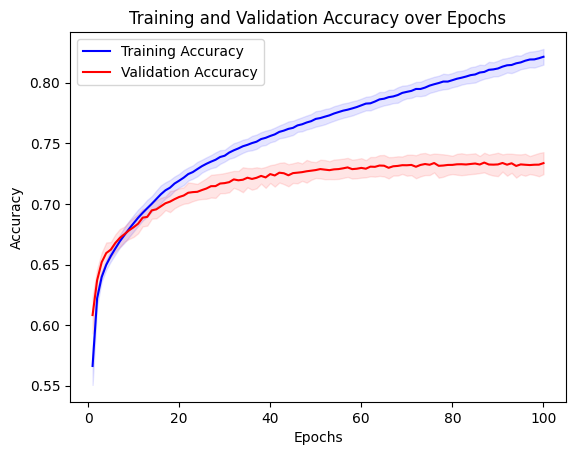

In [11]:
# Calculate the mean accuracy per epoch across all seeds

# print( all_train_accuracies, all_val_accuracies)
train_accuracies_mean = np.mean(all_train_accuracies, axis=0)
val_accuracies_mean = np.mean(all_val_accuracies, axis=0)
# print(train_accuracies_mean, val_accuracies_mean)
# Calculate the standard deviation per epoch across all seeds
train_accuracies_std = np.std(all_train_accuracies, axis=0)
val_accuracies_std = np.std(all_val_accuracies, axis=0)

# Epochs should be a list or array of the same length as the number of epochs
epochs = np.arange(1, 101)

# Now plot using 'epochs' and the calculated means and standard deviations
plt.fill_between(epochs, train_accuracies_mean - train_accuracies_std,
                 train_accuracies_mean + train_accuracies_std, color='blue', alpha=0.1)
plt.plot(epochs, train_accuracies_mean, color='blue', label='Training Accuracy')

plt.fill_between(epochs, val_accuracies_mean - val_accuracies_std,
                 val_accuracies_mean + val_accuracies_std, color='red', alpha=0.1)
plt.plot(epochs, val_accuracies_mean, color='red', label='Validation Accuracy')

plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Answer these questions:

1. Did the network train well?
2. Do you think the variability across seeds is large or small? Why?
3. Load 100 random images from OTHER classes (so, NEITHER cats nor dogs) and put them into the network - how are the images classified? Do these results make “sense”?
4. Taking into account the results from Question 3 - would you use this network to classify birds and airplanes in the “real” world?


# Discussion
<p>
<i>1. Did the network train well?</i>
<b></b>
<br/>
<i>2. Do you think the variability across seeds is large or small? Why?</i>
<b></b>
<br/>
<i>3. Load 100 random images from OTHER classes (so, NEITHER cats nor dogs) and put them into the network - how are the images classified? Do these results make “sense”?</i>
<b></b>
<br/>
<i>4. Taking into account the results from Question 3 - would you use this network to classify birds and airplanes in the “real” world?</i>
<b></b>
</p>

# Part2 Pytorch CNN comparison (40 points):

<p>
Add all code to cnnA3.ipynb.
Following Part 1, now train each of the following modules with the SAME optimizer
and dataloader parameters for the same 30 seeds, adapting each to use the ReLU
functions - use the default parameters as defined in class:
</p>

```python
    class NetWidth(nn.Module), 
    class NetDropout(nn.Module), 
    class NetBatchNormalization(nn.Module), 
    class NetResDeep(nn.Module), 
    class NetWidthProject(nn.Module), 
    class NetWidthEmbed(nn.Module)
```




In [12]:
# Assuming we have the following network definitions with ReLU activations
class NetWidth(nn.Module):
    def __init__(self, n_ch1=32):
        super().__init__()
        # needed later in the forward function
        self.n_ch1 = n_ch1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3,padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = out.view(-1, self.n_ch1 * 8 * 8)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out


class NetDropout(nn.Module):
    def __init__(self, n_ch1=32):
        super().__init__()
        # needed later in the forward function
        self.n_ch1 = n_ch1
        self.conv1 = nn.Conv2d(3, n_ch1, kernel_size=3, padding=1)
        # add the dropout layer
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_ch1, n_ch1 // 2, kernel_size=3, padding=1)
        # add the dropout layer
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_ch1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        # add call to dropout
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        # add call to dropout
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_ch1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out


class NetBatchNormalization(nn.Module):
    def __init__(self, n_ch1=32):
        super().__init__()
        self.n_ch1 = n_ch1
        self.conv1 = nn.Conv2d(3, n_ch1, kernel_size=3, padding=1)
        # Initialize batch normalization layer to match conv1's output channels
        self.conv1_batchnorm = nn.BatchNorm2d(n_ch1)
        self.conv2 = nn.Conv2d(n_ch1, n_ch1 // 2, kernel_size=3, padding=1)
        # Initialize batch normalization layer to match conv2's output channels
        self.conv2_batchnorm = nn.BatchNorm2d(n_ch1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_ch1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)


    def forward(self, x):
        out = self.conv1(x)
        out = self.conv1_batchnorm(out)
        out = F.max_pool2d(torch.relu(out), 2)
        out = self.conv2(out)
        out = self.conv2_batchnorm(out)
        out = F.max_pool2d(torch.relu(out), 2)
        out = out.view(-1, 8 * 8 * self.n_ch1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out
    

class NetSkip(nn.Module):
    def __init__(self, n_ch1=32):
        super().__init__()
        # needed later in the forward function
        self.n_ch1 = n_ch1
        self.conv1 = nn.Conv2d(3, n_ch1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_ch1, n_ch1 // 2, kernel_size=3, padding=1)
        # go deeper!
        self.conv3 = nn.Conv2d(n_ch1 // 2, n_ch1 // 2, kernel_size=3, padding=1)
        # we have now half the size from before
        self.fc1 = nn.Linear(4 * 4 * n_ch1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        # save the input to layer3
        identity = out
        out = self.conv3(out)
        out += identity
        # and add it to the output
        out = F.max_pool2d(torch.relu(out), 2)
        out = out.view(-1, 4 * 4 * self.n_ch1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out
    

class ResBlock(nn.Module):
    def __init__(self, n_ch):
        super(ResBlock, self).__init__()
        # here we now explicitly get rid of the biases as we use BN
        self.conv = nn.Conv2d(n_ch, n_ch, kernel_size=3, padding=1, bias=False)
        # batch normalization
        self.batch_norm = nn.BatchNorm2d(num_features=n_ch)
        # BN is initialized to have 0.5 "variance" and 0 mean
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)
        # this is a special initialization of the convolution weights
        # that was found to help with optimization
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        
        
    def forward(self, x):
        # simple forward function that includes skip connection
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x
    
    
class NetResDeep(nn.Module):
    # the constructor now has a parameter n_blocks that determines how many
    # ResBlocks will be used
    def __init__(self, n_ch1=32, n_blocks=10):
        super().__init__()
        self.n_ch1 = n_ch1
        # initial convolution for embedding
        self.conv1 = nn.Conv2d(3, n_ch1, kernel_size=3, padding=1)
        # add the ResBlocks to the network
        # nn.Sequential makes sure that we can add them together nicely
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_ch=n_ch1)]))
        # note that the "net" effect of the blocks does not reduce the dimensionality
        # of the features - hence, we again have 8x8 "pixels" resolution here
        self.fc1 = nn.Linear(8*8*n_ch1, 32)
        self.fc2 = nn.Linear(32, 2)
        
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_ch1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out


class NetWidthProject(nn.Module):
    def __init__(self, n_ch1=32):
        super().__init__()
        # needed later in the forward function
        self.n_ch1 = n_ch1
        self.conv1 = nn.Conv2d(3, n_ch1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_ch1, n_ch1 // 2, kernel_size=3,padding=1)
        # keeps the number of filters
        self.conv3 = nn.Conv2d(n_ch1 // 2, n_ch1 // 2, kernel_size=1)
        self.fc1 = nn.Linear(8 * 8 * n_ch1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = torch.relu(self.conv3(out))
        out = out.view(-1, 8 * 8 * self.n_ch1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out


class NetWidthEmbed(nn.Module):
    def __init__(self, n_ch1=32):
        super().__init__()
        # needed later in the forward function
        self.n_ch1 = n_ch1
        self.conv1 = nn.Conv2d(3, n_ch1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_ch1, n_ch1 // 2, kernel_size=3,padding=1)
        # reduces the number of filters by 2
        self.conv3 = nn.Conv2d(n_ch1 // 2, n_ch1 // 2, kernel_size=1)
        self.fc1 = nn.Linear(8 * 8 * (n_ch1 // 2), 32)
        self.fc2 = nn.Linear(32, 2)
        
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)  # Size: (batch_size, n_ch1, 16, 16)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)  # Size: (batch_size, n_ch1 // 2, 8, 8)
        out = torch.relu(self.conv3(out))  # Size should still be (batch_size, n_ch1 // 2, 8, 8)
        # Flatten the output for the fully connected layer
        # Make sure the number of features matches the output of the last conv layer
        out = out.view(-1, 8 * 8 * (32 // 2))
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out



In [14]:

net_classes = [NetWidth, NetDropout, NetBatchNormalization, NetResDeep, NetWidthProject, NetWidthEmbed]

# Training parameters
n_epochs = 100
batch_size = 64
learning_rate = 1e-4

# Set up your DataLoaders
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=batch_size, shuffle=False)


total_start_time = time.time()
# Loop over each network class
for NetClass in net_classes:
    # Store metrics for each seed
    all_train_losses = []
    all_train_accuracies = []
    all_val_accuracies = []
    
    start_time = time.time()
    # Loop over each seed
    for seed in range(num_seeds):
        
        print(f"Starting Seed {seed} for {NetClass}.")
        torch.manual_seed(seed)
        np.random.seed(seed)

        # Initialize the network and move it to the device
        model = NetClass().to(device)

        # Define the optimizer and loss function
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        loss_fn = nn.CrossEntropyLoss()

        # Train the model
        train_losses, train_accuracies, val_accuracies = training_loop(
            n_epochs=n_epochs,
            optimizer=optimizer,
            model=model,
            loss_fn=loss_fn,
            train_loader=train_loader,
            val_loader=val_loader
        )

        # Store or log the metrics
        all_train_losses.append(train_losses)
        all_train_accuracies.append(train_accuracies)
        all_val_accuracies.append(val_accuracies)
    
    end_time = time.time()

    mean_train_losses = np.mean([np.mean(va) for va in all_train_losses])
    mean_train_accuracy = np.mean([np.mean(va) for va in all_train_accuracies])
    mean_val_accuracy = np.mean([np.mean(va) for va in all_val_accuracies])
    
    print(f'Mean validation accuracy for {NetClass.__name__}: {mean_val_accuracy:.4f}')
    print(f"30 Seeds for {NetClass} took {end_time - start_time} seconds to run.")


total_end_time = time.time()
print(f"Total time for all NetClasses took {total_end_time - total_start_time} seconds to run.")

Starting Seed 0 for <class '__main__.NetWidth'>.
Starting Seed 1 for <class '__main__.NetWidth'>.
Starting Seed 2 for <class '__main__.NetWidth'>.
Starting Seed 3 for <class '__main__.NetWidth'>.
Starting Seed 4 for <class '__main__.NetWidth'>.
Starting Seed 5 for <class '__main__.NetWidth'>.
Starting Seed 6 for <class '__main__.NetWidth'>.
Starting Seed 7 for <class '__main__.NetWidth'>.
Starting Seed 8 for <class '__main__.NetWidth'>.
Starting Seed 9 for <class '__main__.NetWidth'>.
Starting Seed 10 for <class '__main__.NetWidth'>.
Starting Seed 11 for <class '__main__.NetWidth'>.
Starting Seed 12 for <class '__main__.NetWidth'>.
Starting Seed 13 for <class '__main__.NetWidth'>.
Starting Seed 14 for <class '__main__.NetWidth'>.
Starting Seed 15 for <class '__main__.NetWidth'>.
Starting Seed 16 for <class '__main__.NetWidth'>.
Starting Seed 17 for <class '__main__.NetWidth'>.
Starting Seed 18 for <class '__main__.NetWidth'>.
Starting Seed 19 for <class '__main__.NetWidth'>.
Starting S

<p>

Plot the result for each of the 30 network seeds as a grouped bar graph that has on
the x-axis the different networks with each network having training accuracy and
validation accuracy next to each other. Remember to also include the original results
from Net from Part 1. Please use proper error bars like so (plot is NOT complete):

</p>

<img src="./화면 캡처 2023-11-09 101748.png">


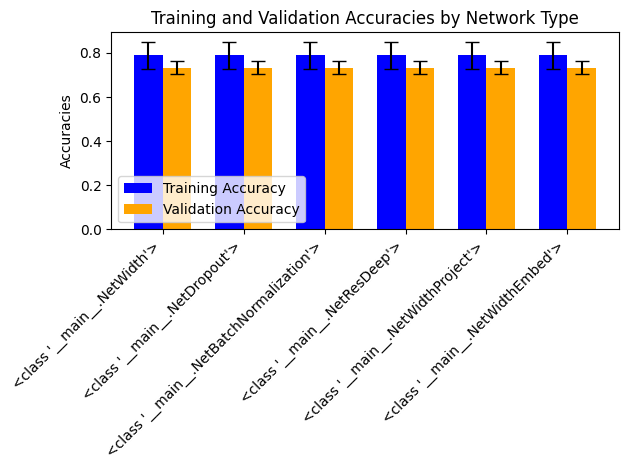

In [16]:
# get names of networks
# net_classes_names = [net_classes[_].__name__ for _ in len(net_classes)]

# Calculate the mean of the training losses across all seeds and epochs
mean_train_losses = np.mean(all_train_losses)

# Calculate the mean of the training and validation accuracies across all seeds and epochs
mean_train_accuracy = np.mean([acc for sublist in all_train_accuracies for acc in sublist])
mean_val_accuracy = np.mean([acc for sublist in all_val_accuracies for acc in sublist])

# Calculate the standard deviation of the training and validation accuracies across all seeds and epochs
std_train_accuracy = np.std([acc for sublist in all_train_accuracies for acc in sublist])
std_val_accuracy = np.std([acc for sublist in all_val_accuracies for acc in sublist])

# Number of networks
n_networks = len(net_classes)

# X locations for the groups
ind = np.arange(n_networks)
# Width of the bars
width = 0.35

# Plotting
fig, ax = plt.subplots()

# Training accuracies
train_rects = ax.bar(ind - width/2, mean_train_accuracy, width, yerr=std_train_accuracy,
                     label='Training Accuracy', color='blue', capsize=5)

# Validation accuracies
val_rects = ax.bar(ind + width/2, mean_val_accuracy, width, yerr=std_val_accuracy,
                   label='Validation Accuracy', color='orange', capsize=5)

# Axes and labels
ax.set_ylabel('Accuracies')
ax.set_title('Training and Validation Accuracies by Network Type')
ax.set_xticks(ind)
ax.set_xticklabels(net_classes, rotation=45, ha="right")
ax.legend()

# Make the labels readable
fig.tight_layout()

# Show the plot
plt.show()

Answer the following questions:

1. Are the resulting architectures (significantly) different in terms of their accuracies (for training and validation)?
2. Taking into account the number of parameters in each model, is there a relationship between training accuracy and number of parameters? (For this, you can also use another, adequate plot to support your answer)

# Discussion

<i>1. Are the resulting architectures (significantly) different in terms of their accuracies (for training and validation)?</i>
<b></b>

<i>2. Taking into account the number of parameters in each model, is there a relationship between training accuracy and number of parameters? (For this, you can also use another, adequate plot to support your answer)</i>
<b></b>

# Part3 Pytorch Multiclass (60 points):

<p>

Add your code to cnnA3.ipynb.
Adapt the network architecture that worked best in Part 2 to now work with the full
10 classes from CIFAR. Keep the batch size and everything else the same and
re-train the network 20 times for 200 epochs, again tracing training and validation
accuracy for each epoch. Note that this will take more time due to the increased size
of the training set!


</p>

<img src="./화면 캡처 2023-11-09 101928.png">


In [17]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Set CUDA_LAUNCH_BLOCKING=1 environment variable
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


# Define the network architecture
class NetBatchNormalization(nn.Module):
    def __init__(self, n_ch1=32):
        super().__init__()
        self.n_ch1 = n_ch1
        self.conv1 = nn.Conv2d(3, n_ch1, kernel_size=3, padding=1)
        # Initialize batch normalization layer to match conv1's output channels
        self.conv1_batchnorm = nn.BatchNorm2d(n_ch1)
        self.conv2 = nn.Conv2d(n_ch1, n_ch1 // 2, kernel_size=3, padding=1)
        # Initialize batch normalization layer to match conv2's output channels
        self.conv2_batchnorm = nn.BatchNorm2d(n_ch1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_ch1 // 2, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv1_batchnorm(out)
        out = F.max_pool2d(torch.relu(out), 2)
        out = self.conv2(out)
        out = self.conv2_batchnorm(out)
        out = F.max_pool2d(torch.relu(out), 2)
        out = out.view(-1, 8 * 8 * self.n_ch1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

# Load the full CIFAR-10 datasets
train_dataset = cifar10
val_dataset = cifar10_val


from torch.utils.data import DataLoader

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Training parameters
n_epochs = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


train_accuracies = []
val_accuracies = []
all_train_preds = []
all_train_targets = []
all_val_preds = []
all_val_targets = []

# Train the network
for seed in range(20):  # Train the network 20 times
    torch.manual_seed(seed)
    np.random.seed(seed)

    model = NetBatchNormalization().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.CrossEntropyLoss()

    seed_train_accuracies = []
    seed_val_accuracies = []
    seed_train_preds = []
    seed_train_targets = []
    seed_val_preds = []
    seed_val_targets = []

    for epoch in range(n_epochs):
        model.train()  # Set the model to training mode
        correct = 0
        total = 0
        train_preds = []
        train_targets = []
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)
            train_preds.extend(predicted.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        seed_train_accuracies.append(correct / total)
        seed_train_preds.append(train_preds)
        seed_train_targets.append(train_targets)

        model.eval()  # Set the model to evaluation mode
        correct = 0
        total = 0
        val_preds = []
        val_targets = []
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                val_preds.extend(predicted.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            print(f'Epoch {epoch+1}/{n_epochs}, Seed {seed+1}')

        seed_val_accuracies.append(correct / total)
        seed_val_preds.append(val_preds)
        seed_val_targets.append(val_targets)

    train_accuracies.append(seed_train_accuracies)
    val_accuracies.append(seed_val_accuracies)
    all_train_preds.append(seed_train_preds)
    all_train_targets.append(seed_train_targets)
    all_val_preds.append(seed_val_preds)
    all_val_targets.append(seed_val_targets)


end_time = time.time()
print(f"20 times took {end_time - start_time} seconds to run.")

Epoch 1/200, Seed 1
Epoch 2/200, Seed 1
Epoch 3/200, Seed 1
Epoch 4/200, Seed 1
Epoch 5/200, Seed 1
Epoch 6/200, Seed 1
Epoch 7/200, Seed 1
Epoch 8/200, Seed 1
Epoch 9/200, Seed 1
Epoch 10/200, Seed 1
Epoch 11/200, Seed 1
Epoch 12/200, Seed 1
Epoch 13/200, Seed 1
Epoch 14/200, Seed 1
Epoch 15/200, Seed 1
Epoch 16/200, Seed 1
Epoch 17/200, Seed 1
Epoch 18/200, Seed 1
Epoch 19/200, Seed 1
Epoch 20/200, Seed 1
Epoch 21/200, Seed 1
Epoch 22/200, Seed 1
Epoch 23/200, Seed 1
Epoch 24/200, Seed 1
Epoch 25/200, Seed 1
Epoch 26/200, Seed 1
Epoch 27/200, Seed 1
Epoch 28/200, Seed 1
Epoch 29/200, Seed 1
Epoch 30/200, Seed 1
Epoch 31/200, Seed 1
Epoch 32/200, Seed 1
Epoch 33/200, Seed 1
Epoch 34/200, Seed 1
Epoch 35/200, Seed 1
Epoch 36/200, Seed 1
Epoch 37/200, Seed 1
Epoch 38/200, Seed 1
Epoch 39/200, Seed 1
Epoch 40/200, Seed 1
Epoch 41/200, Seed 1
Epoch 42/200, Seed 1
Epoch 43/200, Seed 1
Epoch 44/200, Seed 1
Epoch 45/200, Seed 1
Epoch 46/200, Seed 1
Epoch 47/200, Seed 1
Epoch 48/200, Seed 1
E

Plot the accuracy results like in Parts 1,2 as a function of epoch across seeds.
In addition, plot and nicely label a so-called confusion matrix for all 10 classes both
for your final training and validation performance (so, that’s two matrices).
In order to do this, you need to check which class is predicted for a given “true” label
and then simply plot the result as a matrix. Make sure to use percentages!!
Note also, that you need to do this averaged across your 20 seeds!!
Something similar to this should come out, where the true class is on the bottom
axis!

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Flatten the lists of predictions and targets
flat_train_preds = np.concatenate([np.array(preds).flatten() for preds in all_train_preds])
flat_train_targets = np.concatenate([np.array(targets).flatten() for targets in all_train_targets])
flat_val_preds = np.concatenate([np.array(preds).flatten() for preds in all_val_preds])
flat_val_targets = np.concatenate([np.array(targets).flatten() for targets in all_val_targets])

# Now, flat_train_preds and flat_train_targets should be one-dimensional arrays
# Let's try computing the confusion matrix again
try:
    cm_train = confusion_matrix(flat_train_targets, flat_train_preds, normalize='true')
    cm_val = confusion_matrix(flat_val_targets, flat_val_preds, normalize='true')
except ValueError as e:
    print(f"An error occurred: {e}")
    print(f"Shapes - flat_train_targets: {flat_train_targets.shape}, flat_train_preds: {flat_train_preds.shape}")
    # This will help to debug the issue further

# Calculate the confusion matrices for the flat lists
cm_train = confusion_matrix(flat_train_targets, flat_train_preds, normalize='true')
cm_val = confusion_matrix(flat_val_targets, flat_val_preds, normalize='true')

# Plotting the confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(cm_train, annot=True, fmt=".2%", cmap='Blues', ax=ax[0], xticklabels=range(10), yticklabels=range(10))
ax[0].set_title('Training Confusion Matrix')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')

sns.heatmap(cm_val, annot=True, fmt=".2%", cmap='Blues', ax=ax[1], xticklabels=range(10), yticklabels=range(10))
ax[1].set_title('Validation Confusion Matrix')
ax[1].set_xlabel('Predicted Labels')
ax[1].set_ylabel('True Labels')

plt.show()

Now answer each of these questions:

1. Did the networks overfit? a. If not, how could you make them overfit?
2. Which classes can your architecture do well?
3. Which classes have the smallest / largest differences in training versus validation accuracy?
4. Do the confusion patterns in the matrices “make sense”?
Write as much as possible about each of these questions and insert your discussion into the notebook.

# Discussion

<i> 1. Did the networks overfit? a. If not, how could you make them overfit? </i>
<b> </b>
<i> 2. Which classes can your architecture do well?</i>
<b> </b>
<i> 3. Which classes have the smallest / largest differences in training versus validation accuracy?</i>
<b> </b>
<i> 4. Do the confusion patterns in the matrices “make sense”?
Write as much as possible about each of these questions and insert your discussion into the notebook.</i>
<b> </b>